In [5]:
import sys
import warnings

from pathlib import Path
from addict import Dict

sys.path.append('../../')
warnings.filterwarnings('ignore')

In [54]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit

from examples.utils.config import Config
from examples.utils.dataset_adapters import allen_dataset
from pyspikelib import TrainNormalizeTransform, TsfreshVectorizeTransform, TsfreshFeaturePreprocessorPipeline
from pyspikelib.utils import simple_undersampling
from pyspikelib.mpladeq import prettify, beautify_mpl, boxplot

beautify_mpl()

In [55]:
config_dict = {
    'seed': 0,
    'window': 50,
    'step': 20,
    'scale': True,
    'remove_low_variance': True,
    'train_subsample_factor': 0.7,
    'test_subsample_factor': 0.7,
    'delimiter': ',',
    'feature_set': 'full',
    'dataset': '../../data/allen',
    'n_trees': 200,
}

config = Config(config_dict)
np.random.seed(config.seed)

In [56]:
vip_datapath = Path(config.dataset) / 'Vip_spikes_dict_new.pkl'
vip_spike_data = allen_dataset(vip_datapath)
sst_datapath = Path(config.dataset) / 'Sst_spikes_dict_new.pkl'
sst_spike_data = allen_dataset(sst_datapath)

In [57]:
group_split = GroupShuffleSplit(n_splits=1, test_size=0.5)
X = np.hstack([vip_spike_data.series.values, sst_spike_data.series.values])
y = np.hstack(
    [np.ones(vip_spike_data.shape[0]), np.zeros(sst_spike_data.shape[0])]
)
groups = np.hstack([vip_spike_data.groups.values, sst_spike_data.groups.values])

for train_index, test_index in group_split.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

X_train = pd.DataFrame({'series': X_train, 'groups': groups[train_index]})
X_test = pd.DataFrame({'series': X_test, 'groups': groups[test_index]})

In [58]:
normalizer = TrainNormalizeTransform(
    window=config.window, 
    step=config.step, 
    n_samples=None
)
X_train, y_train = normalizer.transform(X_train, y_train, delimiter=config.delimiter)
X_test, y_test = normalizer.transform(X_test, y_test, delimiter=config.delimiter)

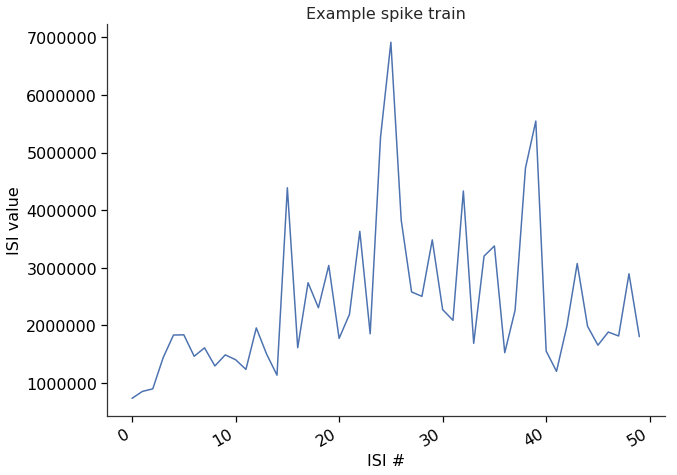

In [59]:
plt.plot(X_train[0, :])
plt.title('Example spike train')
plt.xlabel('ISI #')
plt.ylabel('ISI value')
prettify((15, 8))

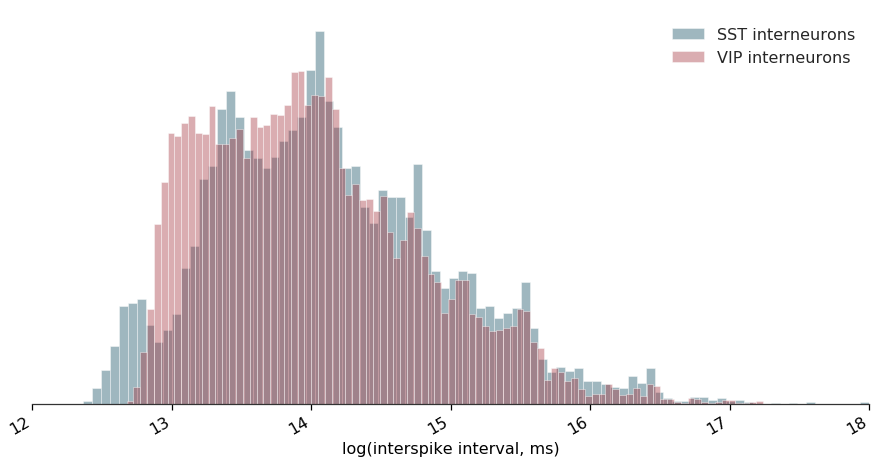

In [60]:
sst_isis = X_train[y_train == 0, :].flatten()
vip_isis = X_train[y_train == 1, :].flatten()

ax = plt.axes()
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

eps = 0.0
sns.distplot(np.log(sst_isis + eps), bins=100, 
             kde=False, norm_hist=True, color=(17/255, 75/255, 95/255));
sns.distplot(np.log(vip_isis + eps), bins=100, 
             kde=False, norm_hist=True, color=(163/255, 51/255, 61/255));

plt.xlabel('log(interspike interval, ms)')
plt.yticks([])
plt.legend(['SST interneurons', 'VIP interneurons'])

plt.xlim(12, 18)

prettify((10, 8))

In [61]:
vectorizer = TsfreshVectorizeTransform(feature_set=config.feature_set)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

Feature Extraction: 100%|██████████| 115/115 [00:05<00:00, 19.39it/s]


In [62]:
preprocessing = TsfreshFeaturePreprocessorPipeline(
        do_scaling=config.scale, 
        remove_low_variance=config.remove_low_variance,
    ).construct_pipeline()
preprocessing.fit(X_train)
X_train = preprocessing.transform(X_train)
X_test = preprocessing.transform(X_test)

In [63]:
print('Dataset size: train {}, test {}'.format(X_train.shape, X_test.shape))
print('Average target: train {}, test {}'.format(y_train.mean(), y_test.mean()))

Dataset size: train (2192, 385), test (1715, 385)
Average target: train 0.6281934306569343, test 0.7457725947521866


In [64]:
num_trials = 10

model = RandomForestClassifier(
    n_estimators=config.n_trees,
    random_state=config.seed,
    max_depth=10,
    n_jobs=-1
)

result_table_columns = ['trial', 'feature_set',
                        'accuracy_test', 'auc_roc_test',
                        'accuracy_train', 'auc_roc_train']
results = {key: [] for key in result_table_columns}
baseline_feature_names = [
    'abs_energy',
    'mean',
    'median',
    'minimum',
    'maximum',
    'standard_deviation',
]
baseline_feature_names = ['value__' + name for name
                            in baseline_feature_names]
metrics_to_collect = {'accuracy': accuracy_score, 'auc_roc': roc_auc_score}

for trial_idx in range(num_trials):
        X_train_sample_balanced, y_train_sample_balanced = simple_undersampling(
            X_train, y_train, subsample_size=config.train_subsample_factor
        )
        X_test_sample_balanced, y_test_sample_balanced = simple_undersampling(
            X_test, y_test, subsample_size=config.test_subsample_factor
        )

        model.fit(X_train_sample_balanced, y_train_sample_balanced)
        for (X, y), dataset_label in [((X_test_sample_balanced, y_test_sample_balanced), 'test'),
                                      ((X_train_sample_balanced, y_train_sample_balanced), 'train')]:
            for metric_name, metric_fn in metrics_to_collect.items():
                model_predictions = model.predict(X) \
                    if metric_name not in ['auc_roc'] else model.predict_proba(X)[:, 1]
                results[metric_name + '_' + dataset_label].append(metric_fn(y, model_predictions))
        results['feature_set'].append(config.feature_set)
        results['trial'].append(trial_idx)

        X_train_sample_balanced = X_train_sample_balanced.loc[:, baseline_feature_names]
        X_test_sample_balanced = X_test_sample_balanced.loc[:, baseline_feature_names]

        model.fit(X_train_sample_balanced, y_train_sample_balanced)

        for (X, y), dataset_label in [((X_test_sample_balanced, y_test_sample_balanced), 'test'),
                                      ((X_train_sample_balanced, y_train_sample_balanced), 'train')]:
            for metric_name, metric_fn in metrics_to_collect.items():
                model_predictions = model.predict(X) \
                    if metric_name not in ['auc_roc'] else model.predict_proba(X)[:, 1]
                results[metric_name + '_' + dataset_label].append(metric_fn(y, model_predictions))

        results['feature_set'].append('simple_baseline')
        results['trial'].append(trial_idx)
    
results = pd.DataFrame(results)

Text(0.5, 1.0, 'Accuracy in interneuron type classification task\n(SST vs. VIP interneurons)')

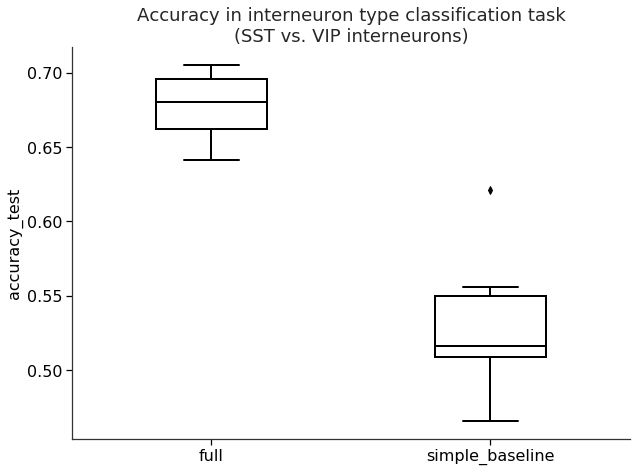

In [65]:
boxplot(x='feature_set', y='accuracy_test', data=results, notch=False)

plt.title('Accuracy in interneuron type classification task\n'\
          '(SST vs. VIP interneurons)', fontsize=18)

Text(0.5, 1.0, 'AUC-ROC score in interneuron type classification task\n(SST vs. VIP interneurons)')

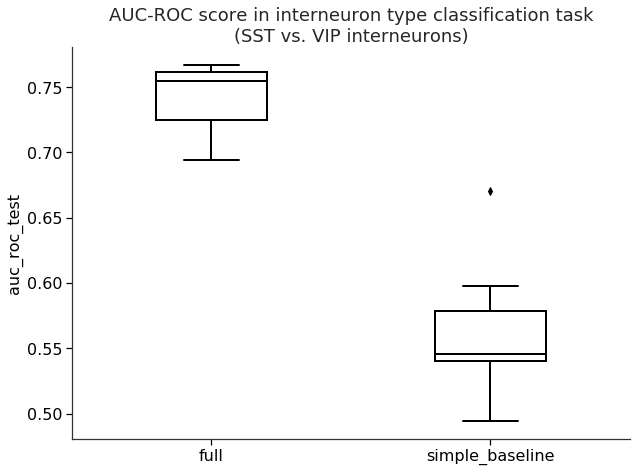

In [66]:
boxplot(x='feature_set', y='auc_roc_test', data=results, notch=False)

plt.title('AUC-ROC score in interneuron type classification task\n'\
          '(SST vs. VIP interneurons)', fontsize=18)